# Take a look at your dataset

In [19]:
!python -c "import torch; print('PyTorch:',torch.__version__)"
!python -c "import torch; print('torch CUDA:',torch.version.cuda)"
!python -c "import torch_geometric; print('PyG (PyTorch Geometric):',torch_geometric.__version__)"
!python --version
# !nvidia-smi

PyTorch: 2.0.0+cu117
torch CUDA: 11.7
PyG (PyTorch Geometric): 2.3.0
Python 3.10.10


In [20]:
import sys
import os
import os.path as osp
import random

import numpy as np
import pandas as pd
from scipy import sparse
from torch_geometric.datasets import MoleculeNet, MovieLens
from torch_geometric.data import Dataset, InMemoryDataset, Data, download_url
from torch_geometric.utils import negative_sampling, convert, to_dense_adj, to_networkx
from torch_geometric.nn import GCNConv, SAGEConv
from torch_geometric.nn.conv import MessagePassing
import torch

import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm

from rdkit import Chem
from torch_geometric.data.collate import collate
from torch_geometric.data.separate import separate

In [21]:

# we chose ESOL from MoleculeNet for instance
data = MoleculeNet(root=".", name="BBBP")
data


Processing...
Done!


BBPB(2050)

In [22]:
data[0]

Data(x=[20, 9], edge_index=[2, 40], edge_attr=[40, 3], smiles='[Cl].CC(C)NCC(O)COc1cccc2ccccc12', y=[1, 1])

In [23]:
# Investigating the dataset
print("Dataset type: ", type(data))
  ############# Your code here ############

### !!! We will consider all graphs as UNDIRECTED !!! ###


print("This database contains ", data.len(), " graphs")
print("Each node of each of the graphs contains ", data.num_node_features, " features")
print("This dataset is separated in ", data.num_classes, " classes")
print()

### We are going to display the information of FIRST GRAPH IN DATASET at the beginning
### after that We are going to display the information of ENTIRE DATASET

### FIRST GRAPH informations

print("The number of FIRST GRAPH nodes IN DATASET: ", data[0].num_nodes)
"""
because of the fact that We want to consider all graphs as undirected 
and in the definition of graph, there are two edges for each edge, 
we divide the output of function in 2
"""
print("The number of FIRST GRAPH edges IN DATASET: ", data[0].num_edges/2)
print("The average of FIRST GRAPH node degree IN DATASET: ", data[0].num_edges/data[0].num_nodes)
print()

### ENTIRE DATASET informations

# First approach for finding the number of all nodes and edges
# It is used a loop for Investigating each Graph
num_nodes_list = []
num_edges_list = []
for grp in data:
    num_nodes_list.append(grp.num_nodes)
    num_edges_list.append(grp.num_edges / 2)
print("The number of total nodes: ", sum(num_nodes_list), "  First approach")
print("The number of total edges: ", sum(num_edges_list), "  First approach")
print("The average of total node degree: ", (2*sum(num_edges_list) / sum(num_nodes_list)), "  First approach")
print()

# Second approach for finding the number of all nodes and edges
# we will merge each data which is a graph in this dataset, together as one huge Graph
# in other word we consider all graphs as one huge graph
huge_data, slices, _ = collate(
                    data[0].__class__, 
                    data_list=data, 
                    increment=False, 
                    add_batch=False, 
                    )
print("The huge graph which include all subgraphs: ", huge_data)
print("Each node of this graph contains", huge_data.num_node_features, "features")

print("The number of total nodes: ", huge_data.num_nodes, "  Second approach")

"""
because of the fact that We want to consider all graphs as undirected 
and in the definition of graph, there are two edges for each edge, 
we divide the output of function in 2
"""

print("The number of total edges: ", huge_data.num_edges / 2, "  Second approach")
print("The average of total node degree: ", huge_data.num_edges / huge_data.num_nodes, "  Second approach")
print()


  #########################################

# edge_index = graph connections
# smiles = molecule with its atoms
# x = node features (32 nodes have each 9 features)
# y = labels (dimension)

Dataset type:  <class 'torch_geometric.datasets.molecule_net.MoleculeNet'>
This database contains  2050  graphs
Each node of each of the graphs contains  9  features
This dataset is separated in  2  classes

The number of FIRST GRAPH nodes IN DATASET:  20
The number of FIRST GRAPH edges IN DATASET:  20.0
The average of FIRST GRAPH node degree IN DATASET:  2.0

The number of total nodes:  49068   First approach
The number of total edges:  52921.0   First approach
The average of total node degree:  2.157047362843401   First approach

The huge graph which include all subgraphs:  Data(x=[49068, 9], edge_index=[2, 105842], edge_attr=[105842, 3], smiles=[2050], y=[2050, 1])
Each node of this graph contains 9 features
The number of total nodes:  49068   Second approach
The number of total edges:  52921.0   Second approach
The average of total node degree:  2.157047362843401   Second approach



In [24]:
# Investigating the features
# Shape: [num_nodes, num_node_features]
display(data[0].x)

tensor([[17,  0,  0,  5,  0,  1,  4,  0,  0],
        [ 6,  0,  4,  5,  3,  0,  4,  0,  0],
        [ 6,  0,  4,  5,  1,  0,  4,  0,  0],
        [ 6,  0,  4,  5,  3,  0,  4,  0,  0],
        [ 7,  0,  3,  5,  1,  0,  4,  0,  0],
        [ 6,  0,  4,  5,  2,  0,  4,  0,  0],
        [ 6,  0,  4,  5,  1,  0,  4,  0,  0],
        [ 8,  0,  2,  5,  1,  0,  4,  0,  0],
        [ 6,  0,  4,  5,  2,  0,  4,  0,  0],
        [ 8,  0,  2,  5,  0,  0,  3,  0,  0],
        [ 6,  0,  3,  5,  0,  0,  3,  1,  1],
        [ 6,  0,  3,  5,  1,  0,  3,  1,  1],
        [ 6,  0,  3,  5,  1,  0,  3,  1,  1],
        [ 6,  0,  3,  5,  1,  0,  3,  1,  1],
        [ 6,  0,  3,  5,  0,  0,  3,  1,  1],
        [ 6,  0,  3,  5,  1,  0,  3,  1,  1],
        [ 6,  0,  3,  5,  1,  0,  3,  1,  1],
        [ 6,  0,  3,  5,  1,  0,  3,  1,  1],
        [ 6,  0,  3,  5,  1,  0,  3,  1,  1],
        [ 6,  0,  3,  5,  0,  0,  3,  1,  1]])

In [25]:
# Investigating the edges in sparse COO format
# Shape [2, num_edges]
data[0].edge_index.t()

tensor([[ 1,  2],
        [ 2,  1],
        [ 2,  3],
        [ 2,  4],
        [ 3,  2],
        [ 4,  2],
        [ 4,  5],
        [ 5,  4],
        [ 5,  6],
        [ 6,  5],
        [ 6,  7],
        [ 6,  8],
        [ 7,  6],
        [ 8,  6],
        [ 8,  9],
        [ 9,  8],
        [ 9, 10],
        [10,  9],
        [10, 11],
        [10, 19],
        [11, 10],
        [11, 12],
        [12, 11],
        [12, 13],
        [13, 12],
        [13, 14],
        [14, 13],
        [14, 15],
        [14, 19],
        [15, 14],
        [15, 16],
        [16, 15],
        [16, 17],
        [17, 16],
        [17, 18],
        [18, 17],
        [18, 19],
        [19, 10],
        [19, 14],
        [19, 18]])

This is subgraph with index 400


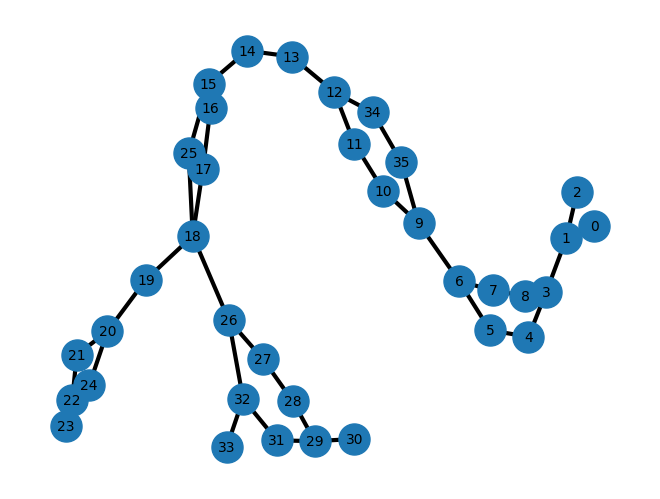

In [26]:
random_index = random.randint(0,  data.len()-1)

### We will make a networkx undirected Graph and draw it for a random subgraph
G= to_networkx(data[random_index], to_undirected=True)

#fig = plt.figure(1, figsize=(10, 10))
print("This is subgraph with index", random_index)
nx.draw(G, with_labels=True, node_size=500, width=3, font_size=10) 

In [27]:
G.is_directed()

False

# Creating your own Dataset:

In [28]:
class MyOwnDataset(Dataset):
    def __init__(self, root, transform=None, pre_transform=None, pre_filter=None):
        super().__init__(root, transform, pre_transform, pre_filter)
    
    @property
    def raw_file_names(self):
        ### This function check necessary files for process function (raw files)
        ### if all files exist in directory already, There is no need to download it again

        return ['BBBP.csv']
    
    @property
    def processed_file_names(self):
        ### This function check output files of process function 
        ### if all output files exist in directory already, There is no need to process raw files again
        # return ['data_1.pt', 'data_2.pt', ...]

        return [f'data_processed_{i}.pt' for i in range(len(self.raw_paths))] 

    def download(self):
        ### This function download necessary files for process function (raw files)
        ### Turn on your VPN !!
        # Download to `self.raw_dir`.
        # Turn on your VPN
        "Downloading..."

        path = download_url("https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/BBBP.csv", self.raw_dir)

    def process(self):
        ### This function Will process raw files

        idx = 0
        for raw_path in self.raw_paths:
            # Read data from `raw_path`.
            # data = Data(...)

            raw_data = pd.read_csv(raw_path)
            
            data_list = []
            black_list = []
            
            for index, mol in raw_data.iterrows(): 
                mol_obj = Chem.MolFromSmiles(mol["smiles"])

                if mol_obj is None:
                    black_list.append(index)
                    print("!! There is a PROBLEM in the data's smiles input with index: ", index, "!!")
                    continue

                # Get node features
                node_feats = self._get_node_features(mol_obj)
                # Get edge features
                edge_feats = self._get_edge_features(mol_obj)
                # Get adjacency info
                edge_index = self._get_adjacency_info(mol_obj)
                # Get labels info
                label = self._get_labels(mol["p_np"])

                # Create data object
                data = Data(x=node_feats, 
                            edge_index=edge_index,
                            edge_attr=edge_feats,
                            y=label,
                            smiles=mol["smiles"]
                            ) 
                
                # create a list of Data
                data_list.append(data)

            
            """
            Here, we need to read and create a list of Data objects and save it into the processed_dir. 
            Because saving a huge python list is rather slow, we collate the list into one huge Data object via collate() before saving. 
            The collated data object has concatenated all examples into one big data object 
            and, in addition, returns a slices dictionary to reconstruct single examples from this object. 
            Finally, we need to load these two objects in the constructor into the properties self.data and self.slices
            """
            data, slices, _ = collate(
                    data_list[0].__class__, 
                    data_list=data_list, 
                    increment=False, 
                    add_batch=False, 
            )

            if self.pre_filter is not None and not self.pre_filter(data):
                continue
            
            if self.pre_transform is not None:
                data = self.pre_transform(data)

            ### save huge Data object
            torch.save((data, slices), osp.join(self.processed_dir, f'data_processed_{idx}.pt'))
            idx += 1

    def _get_node_features(self, mol):
        """ 
        This will return a matrix / 2d array of the shape
        [Number of Nodes, Node Feature size]
        """

        ### Get Adjacency Matrix
        adj_mat = Chem.rdmolops.GetAdjacencyMatrix(mol)
        sprs_adj_mat = sparse.csr_matrix(adj_mat)
        graph_mol = nx.from_scipy_sparse_array(sprs_adj_mat)

        cc_graph_mol = nx.closeness_centrality(graph_mol)
        bc_graph_mol = nx.betweenness_centrality(graph_mol)
        pr_graph_mol = nx.pagerank(graph_mol)
        
        all_node_feats = []
        for atom in mol.GetAtoms():
            node_feats = []

            ### RDKit Features ###
            # Feature 1: Atomic number        
            node_feats.append(atom.GetAtomicNum())
            # Feature 2: Atom degree
            node_feats.append(atom.GetDegree())
            # Feature 3: Formal charge
            node_feats.append(atom.GetFormalCharge())
            # Feature 4: Hybridization
            node_feats.append(atom.GetHybridization())
            # Feature 5: Aromaticity
            node_feats.append(atom.GetIsAromatic())
            # Feature 6: Total Num Hs
            node_feats.append(atom.GetTotalNumHs())
            # Feature 7: Radical Electrons
            node_feats.append(atom.GetNumRadicalElectrons())
            # Feature 8: In Ring
            node_feats.append(atom.IsInRing())
            # Feature 9: Chirality
            node_feats.append(atom.GetChiralTag())

            ### Structural Features ###
            # Feature 10: Closeness Centrality
            node_feats.append(cc_graph_mol[atom.GetIdx()])
            # Feature 11: Betweenness Centrality
            node_feats.append(bc_graph_mol[atom.GetIdx()])
            # Feature 12: PageRank
            node_feats.append(pr_graph_mol[atom.GetIdx()])

            # Append node features to matrix
            all_node_feats.append(node_feats)

        all_node_feats = np.asarray(all_node_feats)
        return torch.tensor(all_node_feats, dtype=torch.float)

    def _get_edge_features(self, mol):
        """ 
        This will return a matrix / 2d array of the shape
        [Number of edges, Edge Feature size]
        """
        all_edge_feats = []

        for bond in mol.GetBonds():
            edge_feats = []
            # Feature 1: Bond type (as double)
            edge_feats.append(bond.GetBondTypeAsDouble())
            # Feature 2: Rings
            edge_feats.append(bond.IsInRing())
            # Append node features to matrix (twice, per direction)
            all_edge_feats += [edge_feats, edge_feats]

        all_edge_feats = np.asarray(all_edge_feats)
        return torch.tensor(all_edge_feats, dtype=torch.float)

    def _get_adjacency_info(self, mol):
        """
        We could also use rdmolops.GetAdjacencyMatrix(mol)
        but we want to be sure that the order of the indices
        matches the order of the edge features
        """
        edge_indices = []
        for bond in mol.GetBonds():
            i = bond.GetBeginAtomIdx()
            j = bond.GetEndAtomIdx()
            edge_indices += [[i, j], [j, i]]

        edge_indices = torch.tensor(edge_indices)
        edge_indices = edge_indices.t().to(torch.long).view(2, -1)
        return edge_indices

    def _get_labels(self, label):
        label = np.asarray([label])
        return torch.tensor(label, dtype=torch.int64)

    def len(self):
        return len(self.processed_file_names)

    def get(self, idx):
        ### This function extract and load each stored Data and return it

        data = torch.load(osp.join(self.processed_dir, f'data_processed_{idx}.pt'))
        data_list = []
        i = 0
        while (True):
            try:
                data_row = separate(
                    cls=data[0].__class__,
                    batch=data[0],
                    idx=i,
                    slice_dict=data[1],
                    decrement=False,
                        )
                data_list.append(data_row)
            except:
                break
            i += 1
        return(data_list)
    

In [29]:
MOD = MyOwnDataset('root')

Processing...


!! There is a PROBLEM in the data's smiles input with index:  59 !!
!! There is a PROBLEM in the data's smiles input with index:  61 !!
!! There is a PROBLEM in the data's smiles input with index:  391 !!
!! There is a PROBLEM in the data's smiles input with index:  614 !!
!! There is a PROBLEM in the data's smiles input with index:  642 !!
!! There is a PROBLEM in the data's smiles input with index:  645 !!
!! There is a PROBLEM in the data's smiles input with index:  646 !!
!! There is a PROBLEM in the data's smiles input with index:  647 !!
!! There is a PROBLEM in the data's smiles input with index:  648 !!
!! There is a PROBLEM in the data's smiles input with index:  649 !!
!! There is a PROBLEM in the data's smiles input with index:  685 !!


Done!


In [30]:
my_data = MOD.get(0)

In [31]:
my_data[0]

Data(x=[20, 12], edge_index=[2, 40], edge_attr=[40, 2], y=[1], smiles='[Cl].CC(C)NCC(O)COc1cccc2ccccc12')

This is subgraph with index 1102


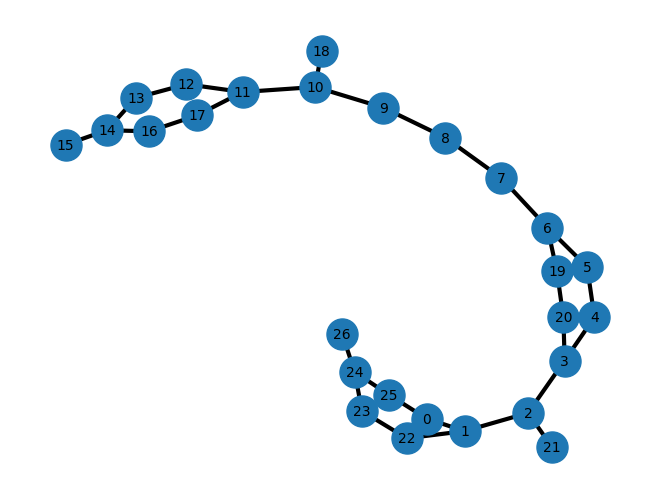

In [32]:
random_index = random.randint(0,  len(my_data)-1)

### We will make a networkx undirected Graph for a random subgraph
G= to_networkx(my_data[random_index], to_undirected=True)
print("This is subgraph with index", random_index)
nx.draw(G, with_labels=True, node_size=500, width=3, font_size=10) 

This induced subgraph belongs to subgraph with index 1102


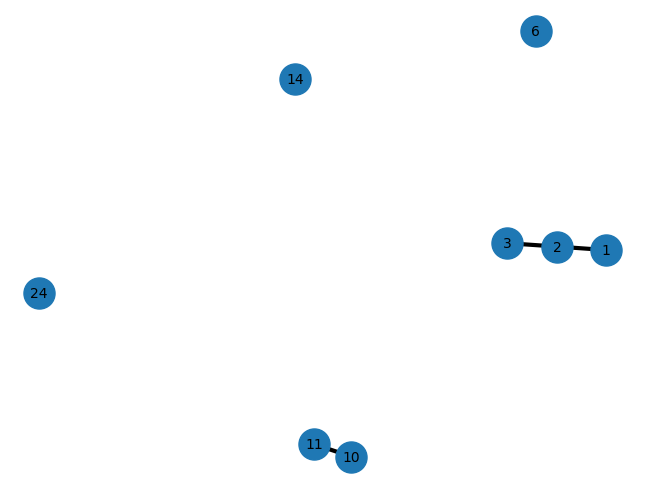

In [33]:
### find average of node degree
avg_deg = (data[random_index].num_edges)/data[random_index].num_nodes

### make induced subgraph
# node_with_great_degree = [item[0] for item in list(G.degree) if (item[1] > avg_deg)]
sub_graph = nx.induced_subgraph(G, [item[0] for item in list(G.degree) if (item[1] > avg_deg)])

### draw induced subgraph
print("This induced subgraph belongs to subgraph with index", random_index)
nx.draw(sub_graph, with_labels=True, node_size=500, width=3, font_size=10)